## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import requests
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels import api as sm
from sklearn.metrics import mean_squared_error
import json
from matplotlib import pyplot as plt
import seaborn as sns   

## Loading data

In [2]:
data_url="https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=IBM&output_size=compact&apikey=GQOYD08LEGBA4H3G"

In [3]:
response=requests.get(data_url)

In [4]:
json_data=response.json()

In [5]:
df=pd.DataFrame(json_data['Time Series (Daily)'])

In [6]:
df=df.T

In [7]:
df.columns=['open', 'high', 'low', 'close', 'adjusted_close',
       'volume', 'dividend_amount', 'split_coefficient']

In [8]:
df

,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
2023-07-14,133.91,133.92,132.94,133.4,133.4,2861496,0.0000,1.0
2023-07-13,133.51,135.07,133.36,133.92,133.92,3221422,0.0000,1.0
2023-07-12,135.07,135.33,132.575,132.84,132.84,3732189,0.0000,1.0
2023-07-11,133.66,134.56,133.23,134.44,134.44,2925238,0.0000,1.0
2023-07-10,131.76,133.05,131.695,132.9,132.9,2369425,0.0000,1.0
...,...,...,...,...,...,...,...,...
2023-02-27,131.42,131.87,130.13,130.49,128.726478059106,2761326,0.0000,1.0
2023-02-24,129.62,130.67,129.22,130.57,128.805396890011,3015907,0.0000,1.0
2023-02-23,131.5,131.7,128.86,130.79,129.022423674998,3725648,0.0000,1.0
2023-02-22,131.9,131.99,130.29,130.97,129.199991044533,3200185,0.0000,1.0


## EDA

In [9]:
df.shape

(100, 8)

In [10]:
df.dtypes

open                 object
high                 object
low                  object
close                object
adjusted_close       object
volume               object
dividend_amount      object
split_coefficient    object
dtype: object

- all the columns are in string type we have to convert

In [11]:
df.open=df.open.astype('float')
df.high=df.high.astype('float')
df.low=df.low.astype('float')
df.close=df.close.astype('float')
df.adjusted_close=df.adjusted_close.astype('float')
df.volume=df.volume.astype('float')
df.split_coefficient=df.split_coefficient.astype('float')

In [12]:
df

,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
2023-07-14,133.91,133.920,132.940,133.40,133.400000,2861496.0,0.0000,1.0
2023-07-13,133.51,135.070,133.360,133.92,133.920000,3221422.0,0.0000,1.0
2023-07-12,135.07,135.330,132.575,132.84,132.840000,3732189.0,0.0000,1.0
2023-07-11,133.66,134.560,133.230,134.44,134.440000,2925238.0,0.0000,1.0
2023-07-10,131.76,133.050,131.695,132.90,132.900000,2369425.0,0.0000,1.0
...,...,...,...,...,...,...,...,...
2023-02-27,131.42,131.870,130.130,130.49,128.726478,2761326.0,0.0000,1.0
2023-02-24,129.62,130.670,129.220,130.57,128.805397,3015907.0,0.0000,1.0
2023-02-23,131.50,131.700,128.860,130.79,129.022424,3725648.0,0.0000,1.0
2023-02-22,131.90,131.990,130.290,130.97,129.199991,3200185.0,0.0000,1.0


In [13]:
df.isna().sum()

open                 0
high                 0
low                  0
close                0
adjusted_close       0
volume               0
dividend_amount      0
split_coefficient    0
dtype: int64

- No null values are present

In [14]:
df.info

<bound method DataFrame.info of               open     high      low   close  adjusted_close     volume  \
2023-07-14  133.91  133.920  132.940  133.40      133.400000  2861496.0   
2023-07-13  133.51  135.070  133.360  133.92      133.920000  3221422.0   
2023-07-12  135.07  135.330  132.575  132.84      132.840000  3732189.0   
2023-07-11  133.66  134.560  133.230  134.44      134.440000  2925238.0   
2023-07-10  131.76  133.050  131.695  132.90      132.900000  2369425.0   
...            ...      ...      ...     ...             ...        ...   
2023-02-27  131.42  131.870  130.130  130.49      128.726478  2761326.0   
2023-02-24  129.62  130.670  129.220  130.57      128.805397  3015907.0   
2023-02-23  131.50  131.700  128.860  130.79      129.022424  3725648.0   
2023-02-22  131.90  131.990  130.290  130.97      129.199991  3200185.0   
2023-02-21  134.00  134.385  131.660  131.71      129.929990  4257210.0   

           dividend_amount  split_coefficient  
2023-07-14         

In [15]:
df.describe()

,open,high,low,close,adjusted_close,volume,split_coefficient
count,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+02,100.0
mean,129.091150,130.017952,128.112473,129.055800,128.125230,4.663271e+06,1.0
std,4.063834,4.104374,4.142374,4.067804,4.482060,3.704860e+06,0.0
min,121.410000,121.970000,120.550000,120.900000,120.900000,1.477149e+06,1.0
25%,126.255000,126.922500,125.127500,125.880000,124.348949,3.221044e+06,1.0
50%,129.265000,130.107450,127.975000,129.075000,127.577223,3.969645e+06,1.0
75%,131.810000,132.952500,131.025000,132.095000,131.840000,4.607194e+06,1.0
max,139.230000,139.469000,137.470000,138.400000,138.400000,3.740017e+07,1.0


In [16]:
df.corr()

,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
open,1.000000,0.983262,0.980087,0.955589,0.931365,-0.165498,-0.178742,NaN
high,0.983262,1.000000,0.985438,0.980129,0.959884,-0.163673,-0.198063,NaN
low,0.980087,0.985438,1.000000,0.986509,0.968527,-0.190650,-0.181726,NaN
close,0.955589,0.980129,0.986509,1.000000,0.984252,-0.191539,-0.195817,NaN
adjusted_close,0.931365,0.959884,0.968527,0.984252,1.000000,-0.189684,-0.156747,NaN
volume,-0.165498,-0.163673,-0.190650,-0.191539,-0.189684,1.000000,-0.003360,NaN
dividend_amount,-0.178742,-0.198063,-0.181726,-0.195817,-0.156747,-0.003360,1.000000,NaN
split_coefficient,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## some visualizations


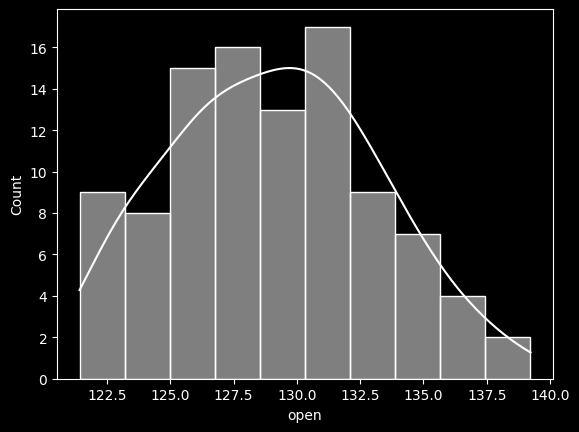

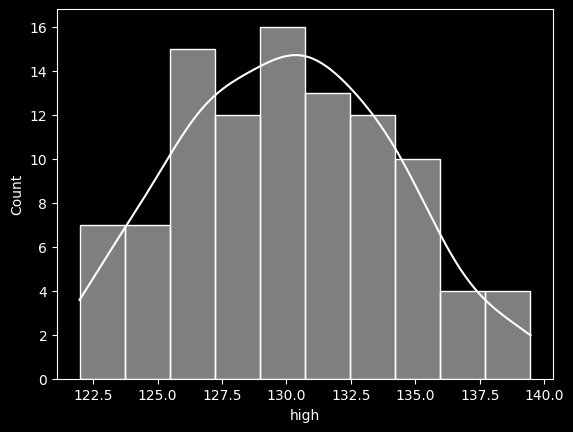

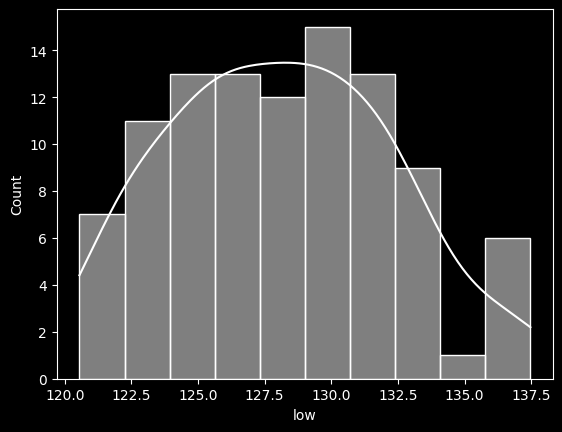

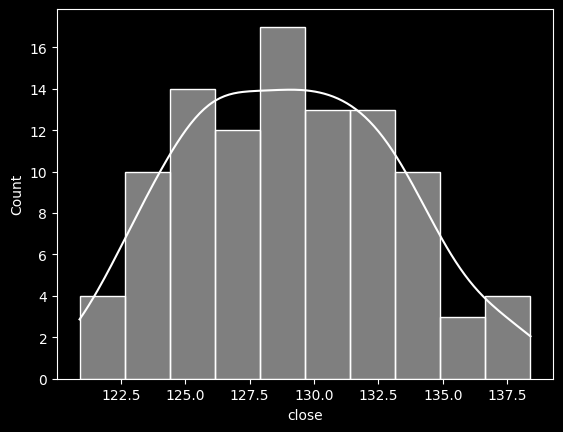

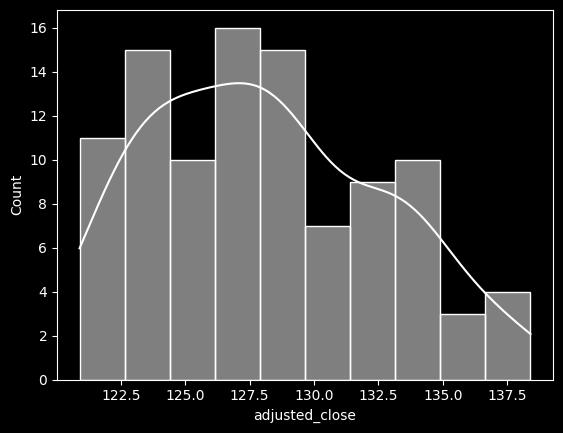

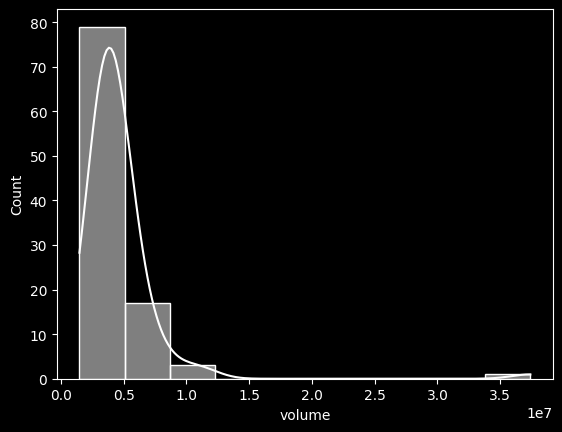

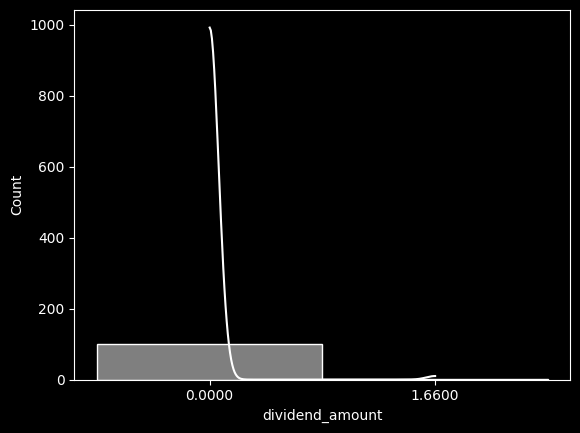

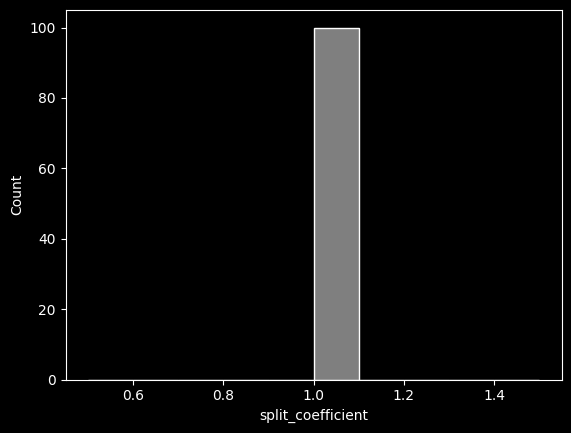

In [17]:
plt.style.use('dark_background')
# plt.figure(figsize=(10,10))
for col in df.columns:
    sns.histplot(data=df,x=col,color='white',kde=True,bins=10)
    plt.show()

In [18]:
# df.to_csv('report.csv',index=False)

In [19]:
data=df[['close']]

In [20]:
data.dtypes

close    float64
dtype: object

C:\Users\asus\AppData\Local\Temp\ipykernel_10572\3529367318.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=data.index,rotation=90)


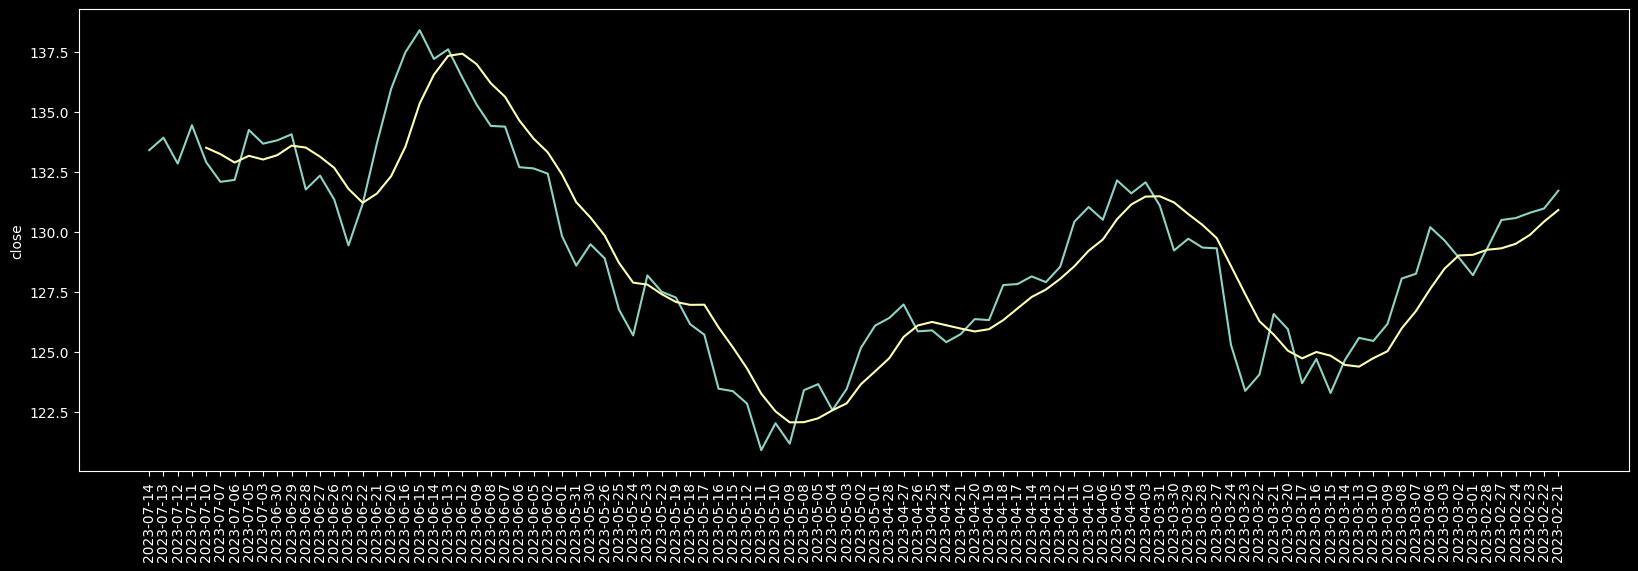

In [21]:
plt.figure(figsize=(20,6))
ax=sns.lineplot(x=data.index,y=data.close)
ax2=sns.lineplot(x=data.index,y=data.close.rolling(5).mean())
ax.set_xticklabels(labels=data.index,rotation=90)
plt.show()

adafuller test

In [22]:
adft=adfuller(data.close)

In [23]:
(test_statistic,p_value,no_of_lags,no_of_observations)=adft[0:4]

In [24]:
p_value

0.33700916751090687

- if p value is less than 0.05 then data is non stationary otherwise it is.
- in our case data is stationary.

In [25]:
result=seasonal_decompose(data[['close']],period=5)

<Figure size 2000x1000 with 0 Axes>

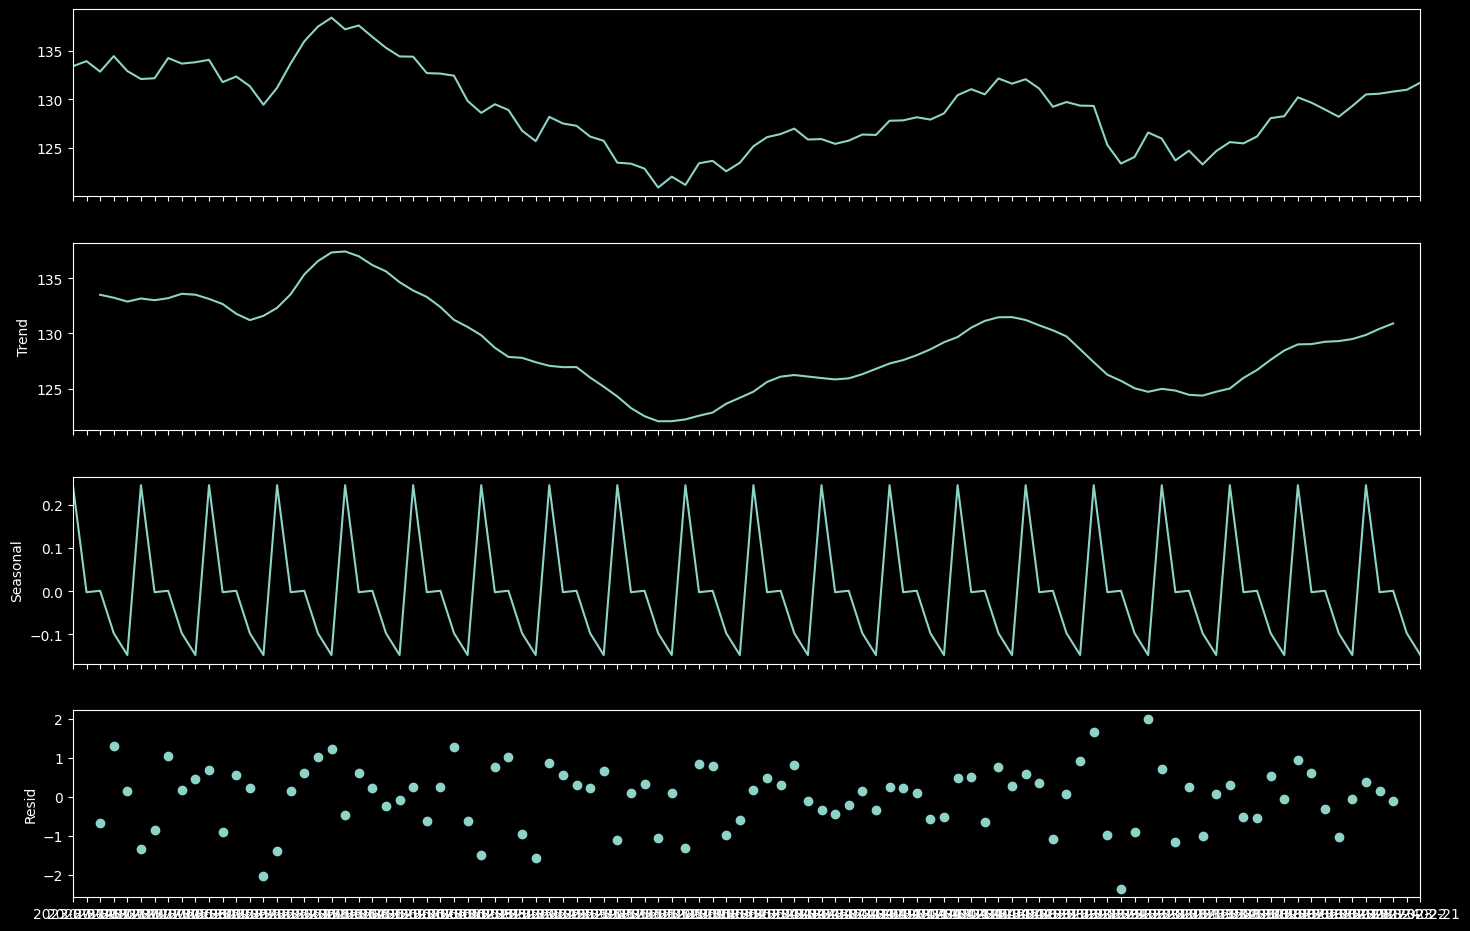

In [26]:
plt.figure(figsize=(20,10))
fig=result.plot()

fig.set_size_inches(17,10)

- plot acf and pacf

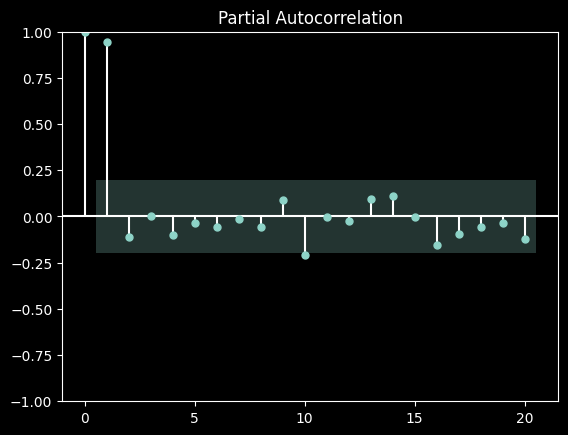

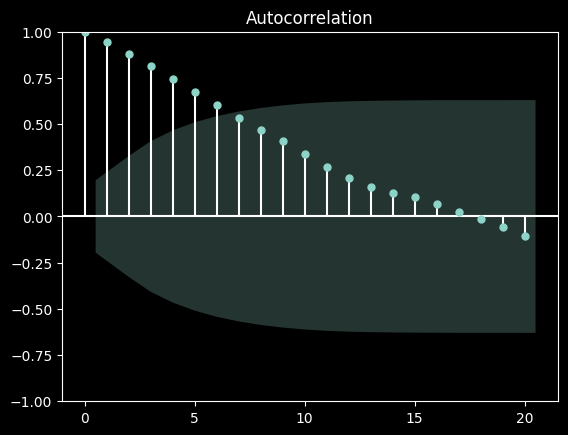

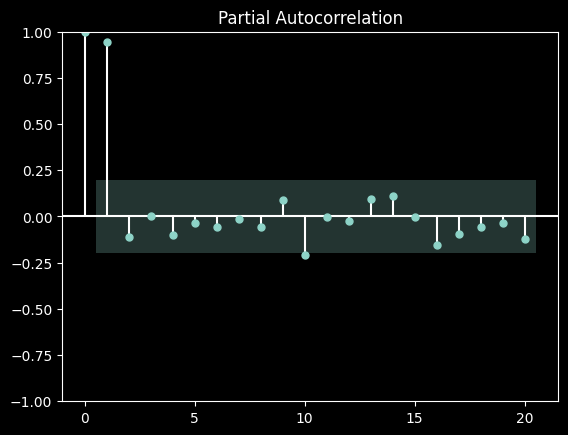

In [27]:
plot_acf(data['close'])
plot_pacf(data['close'])

In [28]:
import warnings
warnings.filterwarnings('ignore')

In [29]:
data.shape

(100, 1)

In [30]:
train_data=data.iloc[0:70]
test_data=data.iloc[70:]

In [31]:
train_data.shape

(70, 1)

In [32]:
test_data.shape

(30, 1)

In [45]:
history=[x for x in train_data['close']]

In [34]:
model=ARIMA(history,order=(1,1,1))

In [35]:
res=model.fit()

In [36]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   70
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -111.991
Date:                Sat, 15 Jul 2023   AIC                            229.982
Time:                        09:59:56   BIC                            236.684
Sample:                             0   HQIC                           232.641
                                 - 70                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6346      0.724      0.876      0.381      -0.785       2.054
ma.L1         -0.5475      0.795     -0.689      0.491      -2.106       1.011
sigma2         1.5038      0.307      4.891      0.000       0.901       2.106
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.22
Prob(Q):                              0.90   Prob(JB):                         0.54
Heteroskedasticity (H):               0.40   Skew:                             0.20
Prob(H) (two-sided):                  0.03   Kurtosis:                         2.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
actual=[x for x in test_data['close']]
pred=[]

In [38]:
x=[x for x in train_data['close']]

In [47]:
for i in range(len(actual)):
    m=ARIMA(history,order=(1,1,1))
    res=m.fit()
    prediction=res.forecast()
    pred.append(prediction[0])
    history.append(actual[i])

In [50]:
len(pred),len(actual)

(30, 30)

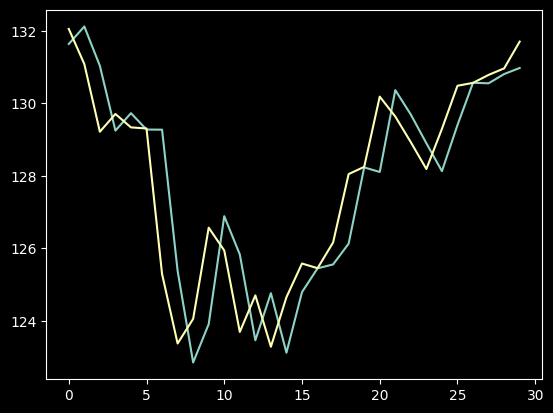

In [52]:
plt.plot(pred)
plt.plot(actual)
plt.show()

In [53]:
def train_arima_model(X, y, arima_order):
    history = [x for x in X]
    predictions = list()
    for t in range(len(y)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(y[t])
    rmse = np.sqrt(mean_squared_error(y, predictions))
    return rmse

In [57]:
def evaluate_models(train,test,p_values,d_values,q_values):
    best_score,best_cfg=float("inf"),None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order=(p,d,q)
                try:
                    rmse=train_arima_model(train,test,order)
                    if rmse<best_score:
                        best_score,best_cfg=rmse,order
                    print(f"ARIMA{order} RMSE={rmse}")
                except:
                    continue
    print(f"best ARIMA{best_cfg} RMSE={best_score}")
    return best_cfg

In [56]:
p_values=range(3)
d_values=range(3)
q_values=range(3)
evaluate_models(train_data.close,test_data.close,p_values,d_values,q_values)

ARIMA(0, 0, 0) RMSE=3.046395252264571
ARIMA(0, 0, 1) RMSE=1.9781735191046057
ARIMA(0, 0, 2) RMSE=1.933982870022648
ARIMA(0, 1, 0) RMSE=1.3596384323292234
ARIMA(0, 1, 1) RMSE=1.3585750577825988
ARIMA(0, 1, 2) RMSE=1.3676411969976783
ARIMA(0, 2, 0) RMSE=1.8086846048888614
ARIMA(0, 2, 1) RMSE=1.403036258799124
ARIMA(0, 2, 2) RMSE=1.3746849752339805
ARIMA(1, 0, 0) RMSE=1.346567356854844
ARIMA(1, 0, 1) RMSE=1.34084467551813
ARIMA(1, 0, 2) RMSE=1.3512133668740567
ARIMA(1, 1, 0) RMSE=1.3590562210656632
ARIMA(1, 1, 1) RMSE=1.399549838029305
ARIMA(1, 1, 2) RMSE=1.3824751453583124
ARIMA(1, 2, 0) RMSE=1.7085579441770158
ARIMA(1, 2, 1) RMSE=1.3739589465067992
ARIMA(1, 2, 2) RMSE=1.3783174793921043
ARIMA(2, 0, 0) RMSE=1.3410161075520552
ARIMA(2, 0, 1) RMSE=1.4276813171166172
ARIMA(2, 0, 2) RMSE=1.3746119808548372
ARIMA(2, 1, 0) RMSE=1.3732579756144268
ARIMA(2, 1, 1) RMSE=1.3868280946168934
ARIMA(2, 1, 2) RMSE=1.3785310810843077
ARIMA(2, 2, 0) RMSE=1.6788900817833865
ARIMA(2, 2, 1) RMSE=1.3868876669